***https://github.com/jeremiedbb/cython-tutorial.git***

In [59]:
import time
import pstats, cProfile
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext cython
%load_ext snakeviz

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


# Speed up your python code
## An application with pairwise distances

<br></br>
### The problem

Let ``X`` and ``Y`` be two sets of points. For all points in `X`, find its closest point in `Y` w.r.t some given distance ``d``.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall x\in X, c(x) = \underset{y\in Y}{\operatorname{argmin}}{d(x,y)}$

We need to
- compute distances between all points in ``X`` and all points in ``Y``.
  Done using scipy ``cdist``.
- for each point in ``X`` find which point in ``Y`` minimize this distance.
  Done using numpy ``argmin``.

In [2]:
def cdist_argmin(X, Y, metric):
    distances = cdist(X, Y, metric=metric)
    argmins = np.argmin(distances, axis=1)
    
    return argmins

For example we can use it to draw the Voronoi diagram of the set of points ``Y``.

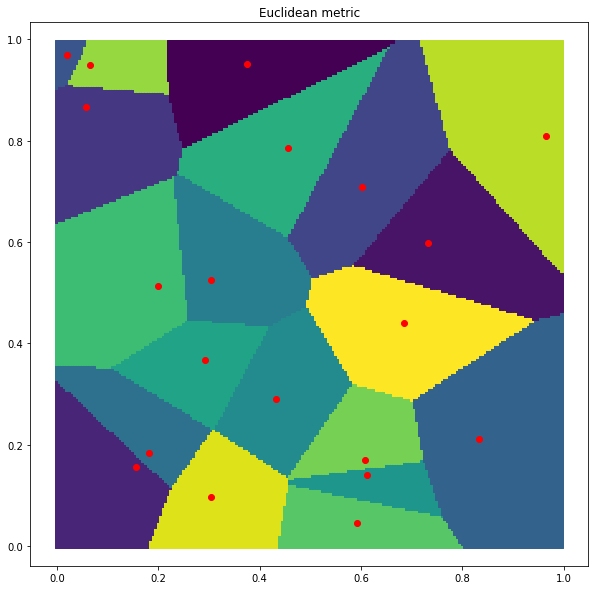

In [4]:
def plot(metric, title):
    Xv = np.array([[0.005*(i//200), 0.005*(i%200)] for i in range(40000)])
    Yv = np.random.RandomState(42).random_sample((20, 2))

    indices = cdist_argmin(Xv,Yv, metric=metric)
    plt.scatter(Xv[:,0], Xv[:,1], c=indices, s=10, marker='s')
    plt.scatter(Yv[:,0], Yv[:,1], color='red')
    plt.axis('equal')
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(title)

plot('euclidean', 'Euclidean metric')

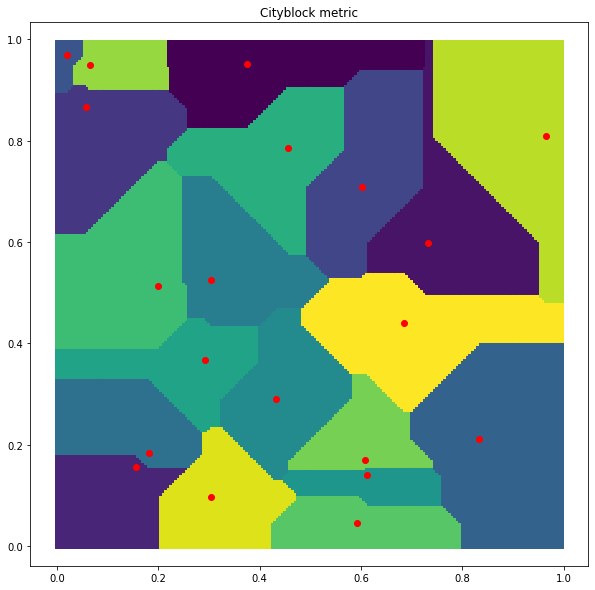

In [5]:
plot('cityblock', 'Cityblock metric')

<br></br>
### Efficiency considerations

Let's generate some data for our benchmarks.

In [6]:
X = np.random.random_sample((10000, 100))
Y = np.random.random_sample((100, 100))

In the ``cdist_argmin`` function, the critical part is the computation of the pairwise distances as shown in the following profiling. If we need to optimize something, this is the part of the code we want to look at.

In [7]:
%snakeviz cdist_argmin(X, Y, metric='cityblock')

 
*** Profile stats marshalled to file '/tmp/tmpp9nu9y9o'. 
Embedding SnakeViz in this document...


``cdist`` is very efficient when using a predefined metric but very slow when using a custom metric.

In [8]:
%timeit cdist(X, Y, metric='cityblock')

42.2 ms ± 785 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
def cityblock(x, y):
    v = np.abs(x - y)
    
    return v.sum()

%timeit -r 3 -n 1 cdist(X, Y, metric=cityblock)

3.81 s ± 46.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The reason is that for a custom metric ``cdist`` relies on generic python code whereas for a predinefined metric it can rely on a specific C implementation.

It's a good candidate to move to compiled code.

<br></br>
### Our custom metric

Through the tutorial we'll use the following metric:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d(x,y) = \sum_{i=0}^{k}{(i + 1) |x_i - y_i|}$

In [10]:
def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)
    
    return v.dot(w)

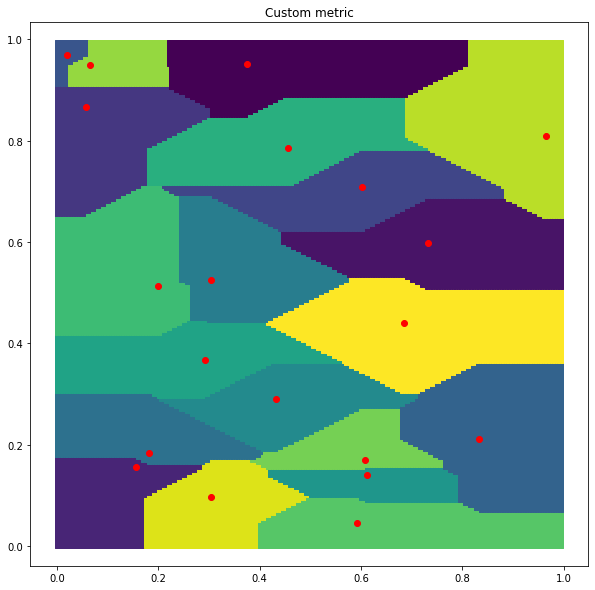

In [11]:
plot(custom_metric, 'Custom metric')

Helpers for accuracy testing and benchmarking

In [12]:
def test(func, X, Y):
    true_indices = cdist_argmin(X, Y)
    indices = func(X, Y)
    if np.all(true_indices == indices):
        print('correct result \o/')
    else:
        print('incorrect result TT')

In [13]:
benchs = pd.DataFrame(columns=['version', 'time (s)', 'speedup'])


def bench(func, X, Y, title):
    t = 0
    for i in range(20):
        t_ = time.time()
        func(X, Y)
        t_ = time.time() - t_
        t += t_
        if t_ > 0.5 and i >=3:
            break
    t /= (i + 1)

    i = benchs.shape[0]
    if i == 0:
        speedup = 1
    else:
        speedup = benchs.iloc[0]['time (s)'] / t
    benchs.loc[i] = [title, t, speedup]

    print(benchs)

<br></br>
### Baseline: 

In [14]:
def cdist_argmin(X, Y):
    distances = cdist(X, Y, metric=custom_metric)
    argmins = np.argmin(distances, axis=1)
    
    return argmins

In [15]:
test(cdist_argmin, X, Y)

correct result \o/


In [16]:
bench(cdist_argmin, X, Y, 'baseline')

    version  time (s) speedup
0  baseline  4.037634       1


<br></br>
### What kind of speed-up can we hope to achieve ?

In [17]:
%timeit cdist(X, Y, metric='cityblock')

43 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
def cityblock(x, y):
    v = np.abs(x - y)
    
    return v.sum()

%timeit -r 3 -n 1 cdist(X, Y, metric=cityblock)

4.24 s ± 93.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<br></br>
### Cython

#### - Python is valid Cython

In [19]:
%%cython -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)
    
    return np.dot(v, w)

def cython_cdist_argmin(X, Y):
    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            distances[i, j] = custom_metric(x, y)
    
    return np.argmin(distances, axis=1)

In [20]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [21]:
bench(cython_cdist_argmin, X, Y, "cython pure python")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731


<br></br>
**Cython annotations** (-a option) show which line contains interaction with python objects.

In [22]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            distances[i, j] = custom_metric(x, y)
    
    return np.argmin(distances, axis=1)

<br></br>
#### - Get rid of python interactions within the nested loop

Move from python variables to typed variables  
``cdef <type> var = ...``

Python ``range`` keyword is compiled into efficient C code  
e.g. ``for i in range(10)``  

In [23]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

    distances = np.empty((X.shape[0], Y.shape[0]))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(distances, axis=1)

``distances`` is still a python object (numpy array). We can get an efficient access to its data using a **typed memoryview**.  

In [24]:
%%cython -a -f

import numpy as np


def custom_metric(x, y):
    v = np.abs(x - y)
    w = np.arange(1, x.shape[0] + 1)

    return np.dot(v, w)


def cython_cdist_argmin(X, Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(distances, axis=1)

``custom_metric`` is a python function with python arguments implemented in pure python.  
- functions maint to be used in python should be defined using `def`  
- functions maint to be used within cython should be defined using `cdef`, and typed.

We also need to use memoryviews for X and Y.

In [25]:
%%cython -a -f

import numpy as np


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [26]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [27]:
bench(cython_cdist_argmin, X, Y, "cdef custom_metric")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856


<br></br>
Cython checks that indexing memoryviews stays within bounds and allows negative indexing. We can disable both using ``boundscheck`` and ``wraparound`` **cython directives**.

In [28]:
%%cython -a -f
#cython: boundscheck=False, wraparound=False

import numpy as np


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [29]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [30]:
bench(cython_cdist_argmin, X, Y, "cython directives")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856
3   cython directives  0.170339  23.7036


<br></br>
#### - Time for optimizations

If we know X and Y will always have the same **memory layout** we can give that information to cython which will produce specialized code.  
Let's assume X and Y are C ordered.

In [31]:
%%cython -a -f
#cython: boundscheck=False, wraparound=False

import numpy as np


cdef double custom_metric(double[::1] x, double[::1] y):
    cdef:
        int n = x.shape[0]
        double tmp
        double res = 0.0
        int i

    for i in range(n):
        tmp = x[i] - y[i]
        if tmp < 0:
            tmp = -tmp
        res += (i + 1) * tmp
        
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [32]:
bench(cython_cdist_argmin, X, Y, "C ordered")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856
3   cython directives  0.170339  23.7036
4           C ordered  0.165827  24.3484


Use functions already implemented in the C standard library: ``fabs``.  
C functions need to be imported with the ``cimport`` keyword.

In [33]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double[::1] x, double[::1] y):
    cdef:
        int n = x.shape[0]
        double res = 0.0
        int i

    for i in range(n):
        res += (i + 1) * fabs(x[i] - y[i])
        
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [34]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [35]:
bench(cython_cdist_argmin, X, Y, "fabs")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856
3   cython directives  0.170339  23.7036
4           C ordered  0.165827  24.3484
5                fabs  0.137433  29.3788


GCC can't **vectorize** reduction.
We can either:
- tell GCC that it's fine to reorder operations
- manually unroll the loop

We can specify compiler flags through the ``-c`` option.

In [36]:
%%cython -c=-Ofast -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double[:] x, double[:] y):
    cdef:
        int n = x.shape[0]
        double res = 0.0
        int i

    for i in range(n):
        res += (i + 1) * fabs(x[i] - y[i])
        
    return res


def cython_cdist_argmin(double[:, :] X, double[:, :] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int i, j

        double[:, :] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(X[i], Y[j])
    
    return np.argmin(np.asarray(distances), axis=1)

In [37]:
bench(cython_cdist_argmin, X, Y, "-Ofast")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856
3   cython directives  0.170339  23.7036
4           C ordered  0.165827  24.3484
5                fabs  0.137433  29.3788
6              -Ofast  0.095239  42.3948


Manually unroll the loop will be worth only if we use pointers.

In [38]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        double res = 0.0
        int i

    for i in range(k):
        res += (i + 1) * fabs(x[i] - y[i])

    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [39]:
bench(cython_cdist_argmin, X, Y, "pointers")

              version  time (s)  speedup
0            baseline  4.037634        1
1  cython pure python  3.747902  1.07731
2  cdef custom_metric  0.666435  6.05856
3   cython directives  0.170339  23.7036
4           C ordered  0.165827  24.3484
5                fabs  0.137433  29.3788
6              -Ofast  0.095239  42.3948
7            pointers  0.136616  29.5545


In [40]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        int rem = k % 4
        double res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [41]:
bench(cython_cdist_argmin, X, Y, "pointers + unrolled loop")

                    version  time (s)  speedup
0                  baseline  4.037634        1
1        cython pure python  3.747902  1.07731
2        cdef custom_metric  0.666435  6.05856
3         cython directives  0.170339  23.7036
4                 C ordered  0.165827  24.3484
5                      fabs  0.137433  29.3788
6                    -Ofast  0.095239  42.3948
7                  pointers  0.136616  29.5545
8  pointers + unrolled loop  0.086662  46.5903


<br></br>
### More cython

#### Profiling cython code

Enabling the ``profile`` cython directive will allow us to profile our code with ``cProfile``.

In [56]:
%%cython -f
#cython: boundscheck=False, wraparound=False, profile=True

import numpy as np
from libc.math cimport fabs


cdef double custom_metric(double* x, double* y, int k):
    cdef:
        int rem = k % 4
        double res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

        double[:, ::1] distances = np.empty((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [57]:
cProfile.runctx("cython_cdist_argmin(X, Y)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("cumtime").print_stats()

Sat Aug 31 20:28:36 2019    Profile.prof

         1000029 function calls in 0.220 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.220    0.220 {built-in method builtins.exec}
        1    0.000    0.000    0.220    0.220 <string>:1(<module>)
        1    0.000    0.000    0.220    0.220 {_cython_magic_0df18b6fb470bc80e59992a1341b9b7e.cython_cdist_argmin}
        1    0.083    0.083    0.220    0.220 _cython_magic_0df18b6fb470bc80e59992a1341b9b7e.pyx:25(cython_cdist_argmin)
  1000000    0.134    0.000    0.134    0.000 _cython_magic_0df18b6fb470bc80e59992a1341b9b7e.pyx:7(custom_metric)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:1110(argmin)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:54(_wrapfunc)
        1    0.002    0.002    0.002    0.002 {method 'argmin' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 numeric.py:469(asarray)

In [60]:
%snakeviz cython_cdist_argmin(X, Y)

 
*** Profile stats marshalled to file '/tmp/tmpzwr9p0ro'. 
Embedding SnakeViz in this document...


<br></br>
#### Generic code with fused types

Our current code is specific to ``double`` dtype (np.float64).

In [42]:
cython_cdist_argmin(X.astype(np.float32), Y.astype(np.float32))

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [43]:
%%cython -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs

ctypedef fused floating:
    float
    double

cdef floating custom_metric(floating* x, floating* y, int k):
    cdef:
        int rem = k % 4
        floating res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(floating[:, ::1] X, floating[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

    dtype = np.float32 if floating is float else np.float64
    cdef floating[:, ::1] distances = np.empty((nx, ny), dtype=dtype)
    
    for i in range(nx):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [44]:
cython_cdist_argmin(X.astype(np.float32), Y.astype(np.float32))

array([37, 42, 72, ..., 98, 88, 56])

<br></br>
#### Parallelism with OpenMP

Simply replace the ``range`` keyword by the ``prange`` keyword.

In [45]:
%%cython -c=-fopenmp -f
#cython: boundscheck=False, wraparound=False

import numpy as np
from libc.math cimport fabs
from cython.parallel cimport prange

ctypedef fused floating:
    float
    double

cdef floating custom_metric(floating* x, floating* y, int k) nogil:
    cdef:
        int rem = k % 4
        floating res = 0.0
        int i

    for i in range(0, k, 4):
        res += ((i + 1) * fabs(x[i] - y[i])
               +(i + 2) * fabs(x[i + 1] - y[i + 1])
               +(i + 3) * fabs(x[i + 2] - y[i + 2])
               +(i + 4) * fabs(x[i + 3] - y[i + 3]))
    
    for i in range(i, rem):
        res += (i + 1) * fabs(x[i] - y[i])
     
    return res


def cython_cdist_argmin(floating[:, ::1] X, floating[:, ::1] Y):
    cdef:
        int nx = X.shape[0]
        int ny = Y.shape[0]
        int k = X.shape[1]
        int i, j

    dtype = np.float32 if floating is float else np.float64
    cdef floating[:, ::1] distances = np.empty((nx, ny), dtype=dtype)
    
    for i in prange(nx, num_threads=2, nogil=True):
        for j in range(ny):
            distances[i, j] = custom_metric(&X[i, 0], &Y[j, 0], k)
    
    return np.argmin(np.asarray(distances), axis=1)

In [46]:
test(cython_cdist_argmin, X, Y)

correct result \o/


In [47]:
bench(cython_cdist_argmin, X, Y, "prange")

                    version  time (s)  speedup
0                  baseline  4.037634        1
1        cython pure python  3.747902  1.07731
2        cdef custom_metric  0.666435  6.05856
3         cython directives  0.170339  23.7036
4                 C ordered  0.165827  24.3484
5                      fabs  0.137433  29.3788
6                    -Ofast  0.095239  42.3948
7                  pointers  0.136616  29.5545
8  pointers + unrolled loop  0.086662  46.5903
9                    prange  0.045859  88.0449


<br></br>
Now a parallel loop with local buffer

In [ ]:
%%cython -c=-fopenmp -f
#cython: wraparound=False, boundscheck=False
import numpy as np
from cython.parallel cimport parallel, prange
from libc.math cimport fabs
from libc.stdlib cimport malloc, free


cdef double manhattan_distance(double *x, double *y, int n) nogil:
    cdef:
        int i
        double res = 0
        int k = n // 4
        int r = n % 4
    
    for i in range(k):
        res += (fabs(x[0] - y[0])
               +fabs(x[1] - y[1])
               +fabs(x[2] - y[2])
               +fabs(x[3] - y[3]))
        x += 4; y += 4
    
    for i in range(r):
        res += fabs(x[i] - y[i])
    
    return res


cdef void manhattan_distances_chunked(double *X, int nx,
                                      double *Y, int ny,
                                      int n_features,
                                      double *distances) nogil:
    cdef:
        int i, j
        
    for i in range(nx):
        for j in range(ny):
            distances[i * ny + j] = manhattan_distance(X + i * n_features, Y + j * n_features, n_features)
                

cdef void argmin_chunked(double *distances, int m, int n, int *indices) nogil:
    cdef:
        int i, j
        int best_j
        double min_dist
        
    for i in range(m):
        min_dist = distances[i * n] 
        best_j = 0
        
        for j in range(1, n):
            if distances[i * n + j] < min_dist:
                min_dist = distances[i * n + j]
                best_j = j
        
        indices[i] = best_j
            


def cython_parallel_pairwise(double[:, ::1] X, double[:, ::1] Y):
    cdef:
        int i
        int n_samples_X = X.shape[0]
        int n_samples_Y = Y.shape[0]
        int n_features = X.shape[1]
        
        int[::1] indices = np.empty(n_samples_X, dtype=np.int32)
        
        double *local_buffer
        int nx = 100
        int n_chunks = n_samples_X // nx

    with nogil, parallel():
        local_buffer = <double *> malloc(nx * n_samples_Y * sizeof(double))
        
        for i in prange(n_chunks):
            manhattan_distances_chunked(&X[i * nx, 0], nx,
                                        &Y[0, 0], n_samples_Y,
                                        n_features,
                                        local_buffer)
        
            argmin_chunked(local_buffer, nx, n_samples_Y, &indices[i * nx])
        
        free(local_buffer)
            
    return np.asarray(indices)

In [ ]:
test(cython_parallel_pairwise, X, Y)

In [ ]:
bench(cython_parallel_pairwise, X, Y, 'cython prange buffer')